# Ensembles

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/203-ensembles.ipynb)

This notebook contains the simple examples of using the ensemble models with ETNA library.

**Table of contents**

* [Loading dataset](#chapter1)  
* [Building pipelines](#chapter2)
* [Ensembles](#chapter3)
    * [VotingEnsemble](#section_3_1)
    * [StackingEnsamble](#section_3_2)
    * [Results](#section_3_3)

In [1]:
%env PYTHONWARNINGS=ignore::FutureWarning

import warnings

warnings.filterwarnings("ignore")

env: PYTHONWARNINGS=ignore::FutureWarning


In [2]:
import pandas as pd

from etna.datasets import TSDataset
from etna.metrics import MAE
from etna.metrics import MAPE
from etna.metrics import MSE
from etna.metrics import SMAPE
from etna.models import CatBoostMultiSegmentModel
from etna.models import NaiveModel
from etna.models import SeasonalMovingAverageModel
from etna.pipeline import Pipeline
from etna.transforms import LagTransform

## 1. Loading dataset <a class="anchor" id="chapter1"></a>

In this notebook we will work with the dataset contains only one segment with monthly wine sales. Working process with the dataset containing more segments will be absolutely the same.

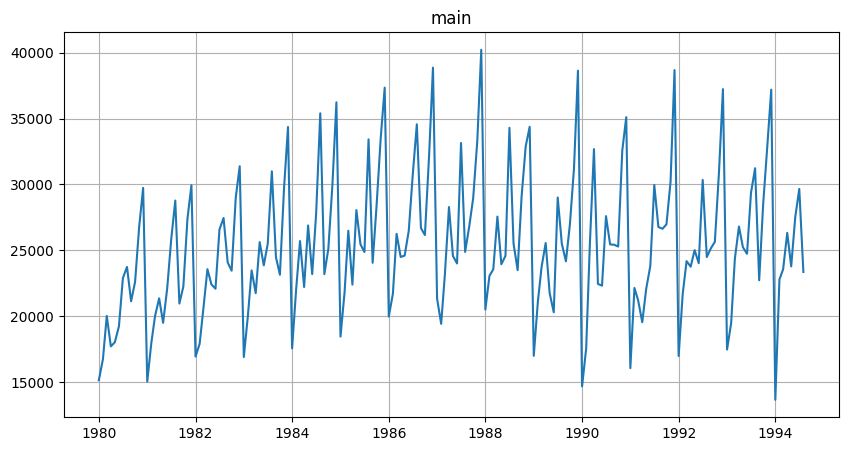

In [3]:
df = pd.read_csv("data/monthly-australian-wine-sales.csv")
df["timestamp"] = pd.to_datetime(df["month"])
df["target"] = df["sales"]
df.drop(columns=["month", "sales"], inplace=True)
df["segment"] = "main"
ts = TSDataset(df=df, freq="MS")
ts.plot()

## 2. Building pipelines <a class="anchor" id="chapter2"></a>

Given the sales' history, we want to select the best model(pipeline) to forecast future sales.

In [4]:
HORIZON = 3
N_FOLDS = 5

Let's build four pipelines using the different models

In [5]:
naive_pipeline = Pipeline(model=NaiveModel(lag=12), transforms=[], horizon=HORIZON)
seasonalma_pipeline = Pipeline(
    model=SeasonalMovingAverageModel(window=5, seasonality=12),
    transforms=[],
    horizon=HORIZON,
)
catboost_pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=[LagTransform(lags=[6, 7, 8, 9, 10, 11, 12], in_column="target")],
    horizon=HORIZON,
)
pipeline_names = ["naive", "moving average", "catboost"]
pipelines = [naive_pipeline, seasonalma_pipeline, catboost_pipeline]

And evaluate their performance on the backtest

In [6]:
metrics = []
for pipeline in pipelines:
    metrics.append(
        pipeline.backtest(
            ts=ts,
            metrics=[MAE(), MSE(), SMAPE(), MAPE()],
            n_folds=N_FOLDS,
            aggregate_metrics=True,
            n_jobs=5,
        )[0].iloc[:, 1:]
    )

[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   15.2s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   23.7s remaining:   35.5s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   34.3s remaining:   22.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   58.7s finished
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)

In [7]:
metrics = pd.concat(metrics)
metrics.index = pipeline_names
metrics

,MAE,MSE,SMAPE,MAPE
naive,2437.466667,1.089199e+07,9.949886,10.222106
moving average,1913.826667,6.113701e+06,7.897570,7.824056
catboost,2271.766726,8.923741e+06,9.376638,10.013138


## 3. Ensembles <a class="anchor" id="chapter3"></a>
To improve the performance of the individual models, we can try to make ensembles out of them. Our library contains two ensembling methods, which we will try on now.

### 3.1 `VotingEnsemble` <a class="anchor" id="section_3_1"></a>

`VotingEnsemble` forecasts future values with weighted averaging of it's `pipelines` forecasts.

In [8]:
from etna.ensembles import VotingEnsemble

By default, `VotingEnsemble` uses **uniform** weights for the pipelines' forecasts. However, you can specify the weights manually using the `weights` parameter. The higher weight the more you trust the base model. In addition, you can set `weights` with the literal `auto`. In this case, the weights of pipelines are assigned with the importances got from `feature_importance_` property of `regressor`.

*Note*: The `weights` are automatically normalized.

In [9]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[1, 9, 4], n_jobs=4)

In [10]:
voting_ensamble_metrics = voting_ensemble.backtest(
    ts=ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=1,
)[0].iloc[:, 1:]
voting_ensamble_metrics.index = ["voting ensemble"]
voting_ensamble_metrics

[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   40.6s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   40.7s
[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   48.0s finished
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   47.8s finished
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)

,MAE,MSE,SMAPE,MAPE
voting ensemble,1972.207943,6.685831e+06,8.172377,8.299714


### 3.2 `StackingEnsemble` <a class="anchor" id="section_3_2"></a>
`StackingEnsemble` forecasts future using the metamodel to combine the forecasts of it's `pipelines`.

In [11]:
from etna.ensembles import StackingEnsemble

By default, `StackingEnsemble` uses only the pipelines' forecasts as features for the `final_model`. However, you can specify the additional features using the `features_to_use` parameter. The following values are possible:

+ **None** - use only the pipelines' forecasts(default)
+ **List[str]** - use the pipelines' forecasts + features from the list
+ **"all"** - use all the available features

*Note:* It is possible to use only the features available for the base models.

In [12]:
stacking_ensemble_unfeatured = StackingEnsemble(pipelines=pipelines, n_folds=10, n_jobs=4)

In [13]:
stacking_ensamble_metrics = stacking_ensemble_unfeatured.backtest(
    ts=ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=1,
)[0].iloc[:, 1:]
stacking_ensamble_metrics.index = ["stacking ensemble"]
stacking_ensamble_metrics

[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s

,MAE,MSE,SMAPE,MAPE
stacking ensemble,1986.453478,7.309679e+06,8.276998,8.328746


In addition, it is also possible to specify the `final_model`. You can use any regression model with the sklearn interface for this purpose.

### 3.3 Results<a class="anchor" id="section_3_3"></a>

Finally, let's take a look at the results of our experiments

In [14]:
metrics = pd.concat([metrics, voting_ensamble_metrics, stacking_ensamble_metrics])
metrics

,MAE,MSE,SMAPE,MAPE
naive,2437.466667,1.089199e+07,9.949886,10.222106
moving average,1913.826667,6.113701e+06,7.897570,7.824056
catboost,2271.766726,8.923741e+06,9.376638,10.013138
voting ensemble,1972.207943,6.685831e+06,8.172377,8.299714
stacking ensemble,1986.453478,7.309679e+06,8.276998,8.328746
